In [1]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

<ipython-input-2-173c0d863eb6>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
import jax
import jax.numpy as jnp
print("Using jax", jax.__version__)

Using jax 0.4.8


In [4]:
a = jnp.zeros((2, 5), dtype=jnp.float32)
print(a)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [5]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


In [6]:
b.__class__

jaxlib.xla_extension.ArrayImpl

In [7]:
b.device()

CpuDevice(id=0)

In [8]:
b_cpu = jax.device_get(b)
print(b_cpu.__class__)

<class 'numpy.ndarray'>


In [9]:
b_gpu = jax.device_put(b_cpu)
print(f'Device put: {b_gpu.__class__} on {b_gpu.device()}')

Device put: <class 'jaxlib.xla_extension.ArrayImpl'> on TFRT_CPU_0


In [10]:
b_cpu + b_gpu

Array([ 0,  2,  4,  6,  8, 10], dtype=int32)

In [11]:
jax.devices()

[CpuDevice(id=0)]

In [12]:
b_new = b.at[0].set(1)
print('Original array:', b)
print('Changed array:', b_new)

Original array: [0 1 2 3 4 5]
Changed array: [1 1 2 3 4 5]


In [13]:
rng = jax.random.PRNGKey(42)

In [14]:
# A non-desirable way of generating pseudo-random numbers...
jax_random_number_1 = jax.random.normal(rng)
jax_random_number_2 = jax.random.normal(rng)
print('JAX - Random number 1:', jax_random_number_1)
print('JAX - Random number 2:', jax_random_number_2)

# Typical random numbers in NumPy
np.random.seed(42)
np_random_number_1 = np.random.normal()
np_random_number_2 = np.random.normal()
print('NumPy - Random number 1:', np_random_number_1)
print('NumPy - Random number 2:', np_random_number_2)

JAX - Random number 1: -0.18471177
JAX - Random number 2: -0.18471177
NumPy - Random number 1: 0.4967141530112327
NumPy - Random number 2: -0.13826430117118466


In [15]:
rng, subkey1, subkey2 = jax.random.split(rng, num=3)  # We create 3 new keys
jax_random_number_1 = jax.random.normal(subkey1)
jax_random_number_2 = jax.random.normal(subkey2)
print('JAX new - Random number 1:', jax_random_number_1)
print('JAX new - Random number 2:', jax_random_number_2)

JAX new - Random number 1: 0.107961535
JAX new - Random number 2: -1.2226542


In [16]:
def simple_graph(x):
    x = x + 2
    x = x ** 2
    x = x + 3
    y = x.mean()
    return y

inp = jnp.arange(3, dtype=jnp.float32)
print('Input', inp)
print('Output', simple_graph(inp))

Input [0. 1. 2.]
Output 12.666667


In [17]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

In [18]:
global_list = []

# Invalid function with side-effect
def norm(x):
    global_list.append(x)
    x = x ** 2
    n = x.sum()
    n = jnp.sqrt(n)
    return n

jax.make_jaxpr(norm)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = integer_pow[y=2] a
    c:f32[] = reduce_sum[axes=(0,)] b
    d:f32[] = sqrt c
  in (d,) }

In [18]:
jaxpr ::= { lambda Var* ; Var+.
            let Eqn*
            in  [Expr+] }

In [19]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print('Gradient', gradients)

Gradient [1.3333334 2.        2.6666667]


In [20]:
jax.make_jaxpr(grad_function)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0 d
    f:f32[3] = add c 3.0
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0
    h:f32[] = div 1.0 3.0
    i:f32[3] = broadcast_in_dim[broadcast_dimensions=() shape=(3,)] h
    j:f32[3] = mul i e
  in (j,) }

In [21]:
val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

In [22]:
jitted_function = jax.jit(simple_graph)

In [23]:
rng, normal_rng = jax.random.split(rng)
large_input = jax.random.normal(normal_rng, (1000,))
# Run the jitted function once to start compilation
_ = jitted_function(large_input)

In [24]:
%%timeit
simple_graph(large_input).block_until_ready()

229 µs ± 9.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
%%timeit
jitted_function(large_input).block_until_ready()

8.22 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input)  # Apply once to compile

In [27]:
%%timeit
grad_function(large_input).block_until_ready()

6.68 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
!pip install jraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.3 MB/s eta 0:00:00


In [29]:
from flax import linen as nn

In [30]:
class SimpleClassifier(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    def setup(self):
        # Create the modules we need to build the network
        # nn.Dense is a linear layer
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x

##### Compact defining of a neural net

In [31]:
class SimpleClassifierCompact(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [32]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
# Printing the model shows its attributes
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [33]:
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2))  # Batch size 8, input size 2
# Initialize the model
params = model.init(init_rng, inp)
print(params)

FrozenDict({
    params: {
        linear1: {
            kernel: Array([[ 0.31476858, -0.46477678, -0.78620416, -0.48842612, -0.65373844,
                     0.38925445,  0.3038055 ,  0.0417986 ],
                   [-0.32982358,  1.1110363 ,  0.54909384, -0.81688154,  0.4005725 ,
                    -0.86659867,  1.2087963 ,  1.0364621 ]], dtype=float32),
            bias: Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        linear2: {
            kernel: Array([[-0.2797181 ],
                   [-0.74667746],
                   [ 0.29791605],
                   [-0.26267233],
                   [-0.50843847],
                   [ 0.04573093],
                   [-0.4725701 ],
                   [ 0.50458497]], dtype=float32),
            bias: Array([0.], dtype=float32),
        },
    },
})


In [34]:
model.apply(params, inp)

Array([[-0.4836821 ],
       [ 0.04365462],
       [ 0.0666853 ],
       [-0.34203655],
       [ 0.48351482],
       [ 0.37424877],
       [ 0.14232653],
       [-0.5916512 ]], dtype=float32)

In [35]:
import torch.utils.data as data

In [36]:
class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [37]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), 1)


In [38]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

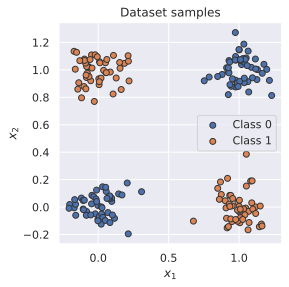

In [40]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [41]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [42]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 0.15231241  1.0538911 ]
 [-0.05767713  1.0755391 ]
 [-0.00190162 -0.10025293]
 [ 1.0681953  -0.03102668]
 [ 0.9181779   0.20923872]
 [-0.0985726   0.05040465]
 [ 1.1644968   0.9750964 ]
 [-0.06800247  1.0232254 ]]
Data labels (8,) 
 [1 1 0 1 1 0 0 1]


In [43]:
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

In [44]:
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=0.1)

In [45]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [46]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

In [47]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.5873672, dtype=float32), Array(0.875, dtype=float32))

In [48]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

In [49]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

In [50]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)


In [51]:
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [52]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
from flax.training import checkpoints

In [54]:
checkpoints.save_checkpoint(ckpt_dir='my_checkpoints/',  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

'my_checkpoints/my_model100'

In [55]:
loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir='my_checkpoints/',   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='my_model'  # Checkpoint file name prefix
                                            )

In [56]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)

In [57]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [58]:
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


In [59]:
trained_model = model.bind(trained_model_state.params)

In [60]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape

(8, 1)

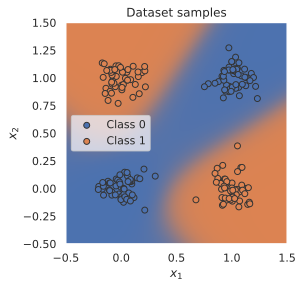

In [61]:
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()

In [62]:
def simple_linear(x, w, b):
    # We could already vectorize this function with matmul, but as an example,
    # let us use a non-vectorized function with same output
    return (x[:,None] * w).sum(axis=0) + b

In [63]:
# Example inputs
rng, x_rng, w_rng, b_rng = jax.random.split(rng, 4)
x_in = jax.random.normal(x_rng, (4,))
w_in = jax.random.normal(w_rng, (4, 3))
b_in = jax.random.normal(b_rng, (3,))

simple_linear(x_in, w_in, b_in)

Array([-0.5393317,  1.4906642,  0.7108946], dtype=float32)

In [64]:
vectorized_linear = jax.vmap(simple_linear,
                             in_axes=(0, None, None),  # Which axes to vectorize for each input
                             out_axes=0  # Which axes to map to in the output
                            )

In [65]:
x_vec_in = jnp.stack([x_in]*5, axis=0)

vectorized_linear(x_vec_in, w_in, b_in)

Array([[-0.5393317,  1.4906642,  0.7108946],
       [-0.5393317,  1.4906642,  0.7108946],
       [-0.5393317,  1.4906642,  0.7108946],
       [-0.5393317,  1.4906642,  0.7108946],
       [-0.5393317,  1.4906642,  0.7108946]], dtype=float32)

In [66]:
parameters = jax.tree_leaves(model_state.params)
print('We have parameters with the following shapes:', ', '.join([str(p.shape) for p in parameters]))
print('Overall parameter count:', sum([np.prod(p.shape) for p in parameters]))

We have parameters with the following shapes: (8,), (2, 8), (1,), (8, 1)
Overall parameter count: 33


<ipython-input-66-40d1d4eadaa1>:1: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  parameters = jax.tree_leaves(model_state.params)


In [67]:
jax.tree_map(lambda p: p.shape, model_state.params)

FrozenDict({
    params: {
        linear1: {
            bias: (8,),
            kernel: (2, 8),
        },
        linear2: {
            bias: (1,),
            kernel: (8, 1),
        },
    },
})

In [68]:
for i in range(10):
    jitted_function(jnp.zeros(i+1,))

In [69]:
# Running the functions a second time will not print out anything since
# the functions are already jitted for the respective input shapes.
for i in range(10):
    jitted_function(jnp.zeros(i+1,))